# object and exposure information

* https://www.tng.iac.es/info/la_palma_sky.html
* https://www.not.iac.es/instruments/alfosc/
    * https://www.not.iac.es/instruments/detectors/CCD14/
    * https://www.not.iac.es/instruments/alfosc/grisms/

In [3]:
mag=    18     # input object magnitude in AB mags
# mag=    ???     # input object magnitude in AB mags
time =  100     # input exposure time in seconds
airmass= 1.4     # assumed object airmass
seeing= 1      # input seeing in arcsec

# how much extinction is occuring ?
# https://research.ast.cam.ac.uk/cmt/camc_extinction.html
# from http://www.tng.iac.es/info/la_palma_sky.html 

extinction_coefficient_R =  0.11 # extinction coefficient valid for the R-band
extinct   = extinction_coefficient_R *airmass  # scales with the airmass
mag_sky = 20.2           # sky background magnitude depends on the moon illumination and the wavelength. 
                       # Here you should input the value from 7 days from new moon in the R band. 
                       # Units are in mag/square arcsec 
            

# Telescope setup

In [4]:
tel_rad =  125      # telescope radius in cm - numbers here are valid for the NOT
inner_rad = 34/2.  # inner hole in cm

epsilon=0.28       # total telescope efficiency relative to a value of 1. = 28% (taken from ETC spectroscopy online)

# Instrument setup

In [5]:
wavelength= 6500    # input central wavelength in Å of observation
slit_width= 1     # arcsec 

slit_length = 20. # arcsec

# compute the fraction of recovered light for the ALFOSC detector, and grism number 8.
# http://www.not.iac.es/instruments/alfosc/
# see Detector page, Grism page and other links)

pix_scale= 0.2138     # arcsec/pixel  for grism no 8 in ALFOSC 
delta_s =  1.4     # AA/pixel  for the ALFOSC detector
RON  =  3.0        # read noise in e-/pixel for the ALFOSC detector
Dark =  1.3        # e-/pixel/hour for the ALFOSC detector

det_eff=0.956      # detetor efficiency (QE) of detector
#http://www.not.iac.es/instruments/detectors/CCD14/e2v_result_sheet_CCD122340-10-01.pdf

# Now perform the computations of photon energy and flux from the object and the sky

In [6]:
import numpy as np

Area=np.pi*(tel_rad**2 - inner_rad**2)
f_lam=10**((mag+extinct+2.406+5.*np.log10(wavelength))/(-2.5))   # Eq. 5 
f_lam_sky=10**((mag_sky+2.406+5.*np.log10(wavelength))/(-2.5))   # Eq. 5
E_gamma= 6.6262e-27*2.9979e18/wavelength                         # Eq. 6

print('E gamma:   %5.2e' % E_gamma , 'erg')
print('f_lam:     %5.2e' % f_lam ,'erg/cm^2/s/Å')
print('f_lam,sky: %5.2e' % f_lam_sky, 'erg/cm^2/s/Å')

E gamma:   3.06e-12 erg
f_lam:     1.41e-16 erg/cm^2/s/Å
f_lam,sky: 2.15e-17 erg/cm^2/s/Å


In [7]:
import math
n_pix=2.*seeing/pix_scale                                               # line spreads over this many pixels  (eq. 2)
slit_loss = 1-math.erfc( (slit_width/2.) / (np.sqrt(2)*seeing/2.35482)) # fraction of light inside the slit  (eq.8)

print('slit loss:   %4.2f' %slit_loss)

slit loss:   0.76


In [8]:
#calculate photon counts per bin
N_obj = epsilon * f_lam * Area * time * delta_s * slit_loss/ E_gamma    # in gamma/s/AA   (Eq. 10)
Omega_sky = pix_scale * slit_width                                      # arcsec**2/pixel  (eq. 11)
N_sky = epsilon * f_lam_sky * Area * time * delta_s * Omega_sky / E_gamma  # in gamma/s/AA/pixel  (Eq. 12)

# convert to e-/pixel in dispersion direction
N_obj=N_obj*det_eff
N_sky=N_sky*det_eff


print('N_obj %4.2f ' %N_obj ,' object counts per pixel')
print('N_obj %4.2f ' %N_sky, ' sky counts per pixel')

N_obj 63.53   object counts per pixel
N_obj 2.71   sky counts per pixel


## main computation of S/N ratio
* [compare - calculator](https://www.not.iac.es/observing/forms/signal/index.php)
* 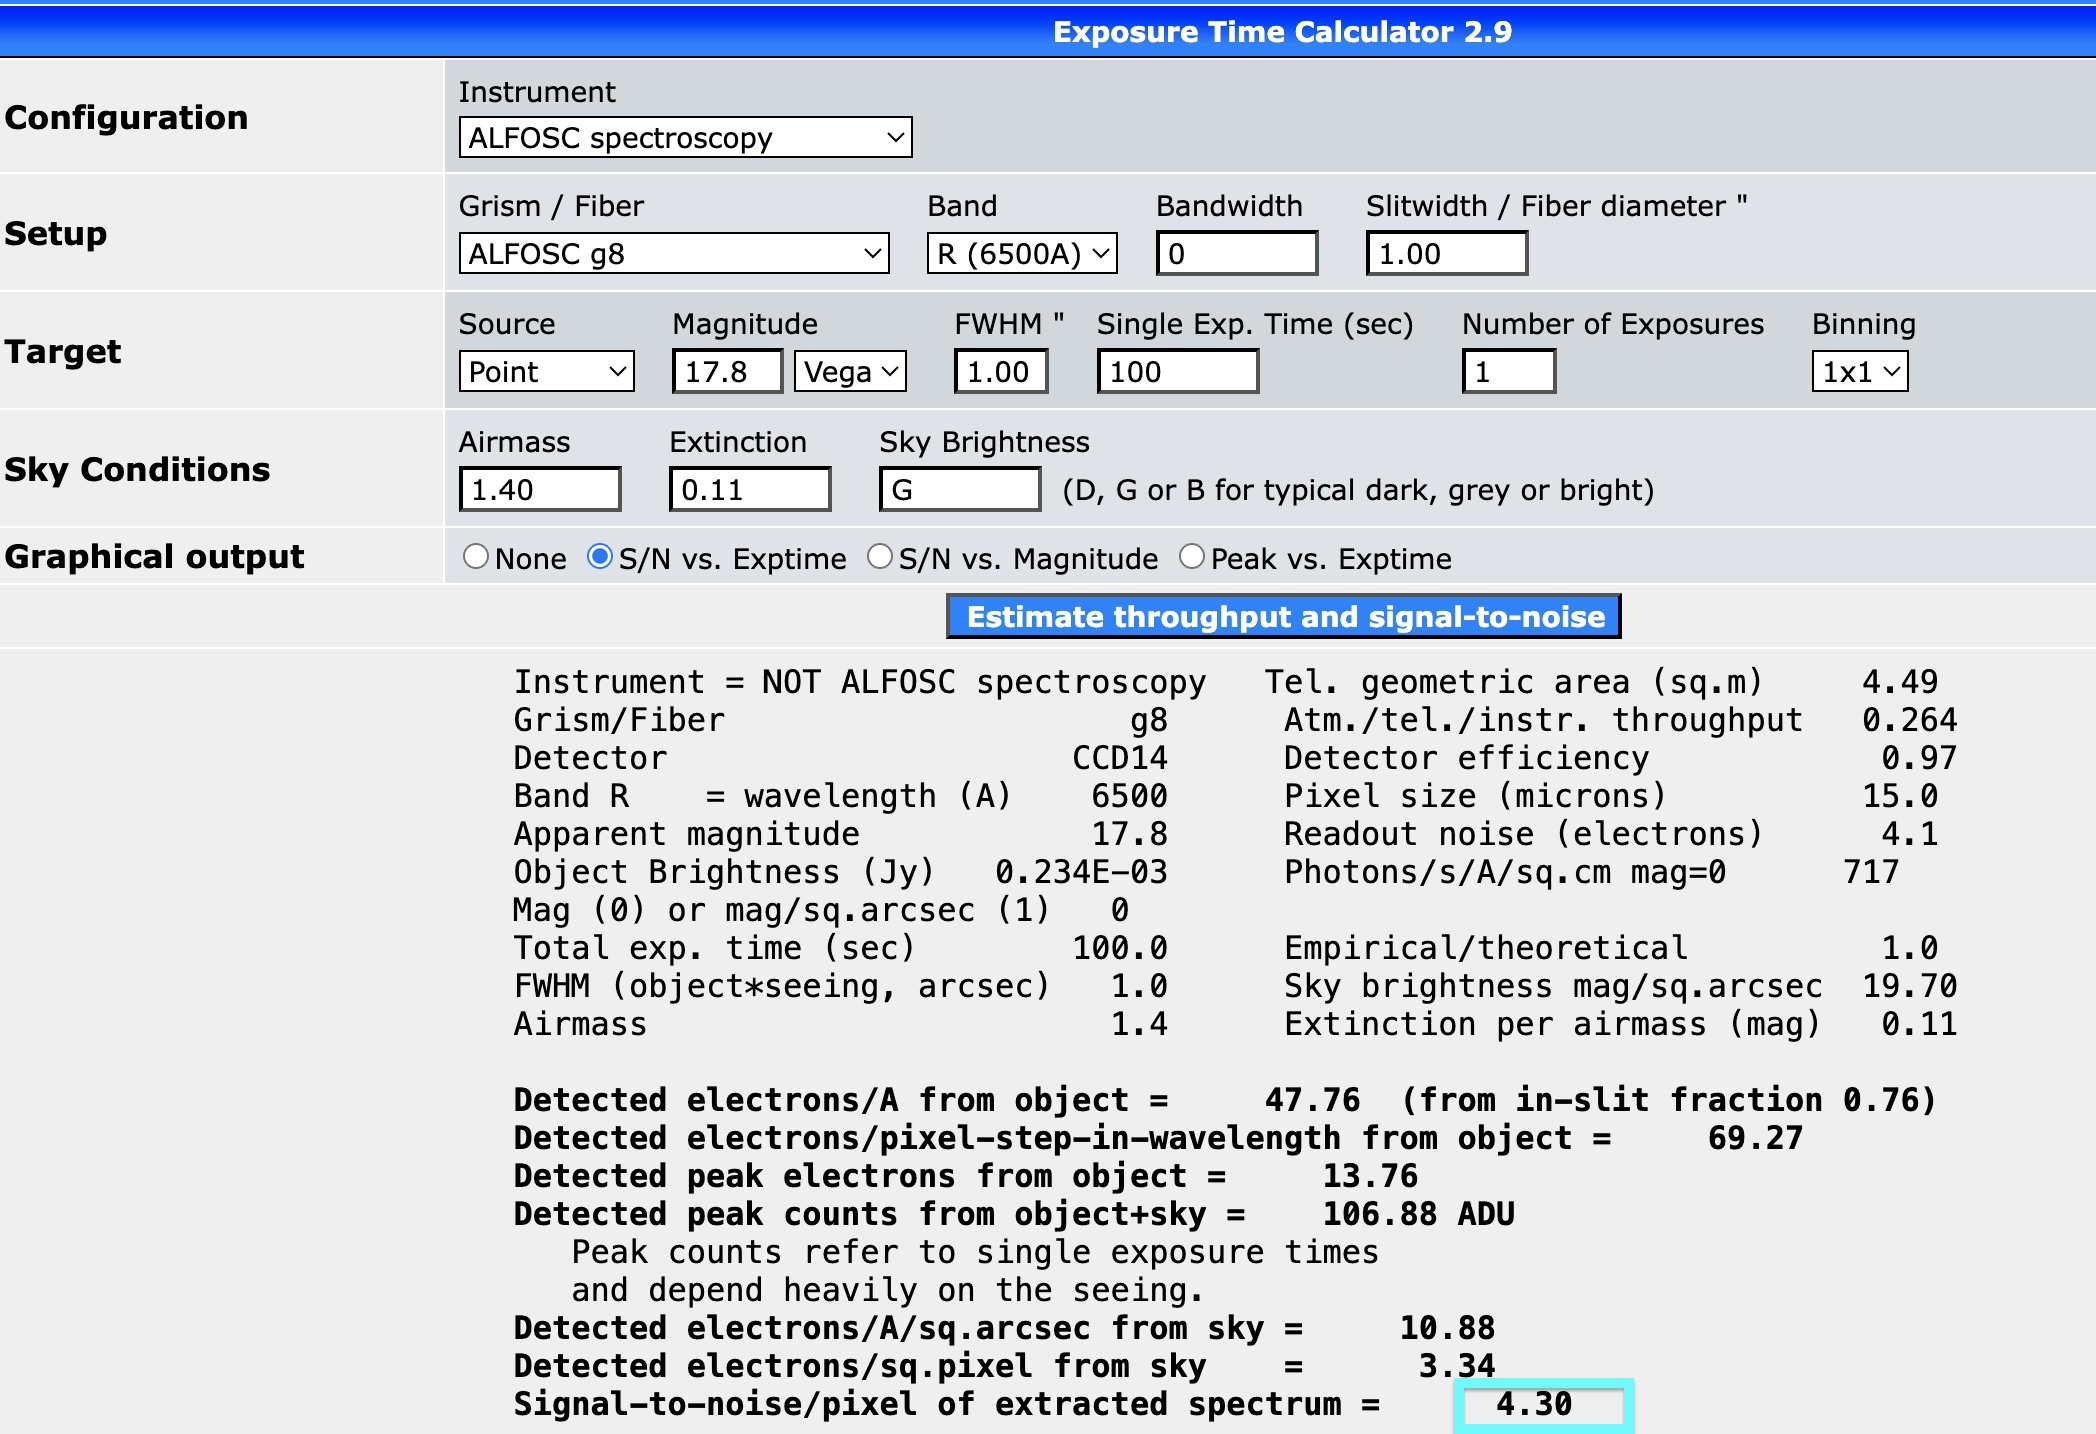

In [9]:
noise = N_obj + N_sky*n_pix +n_pix*RON**2 +n_pix*Dark*(time/3600.)   # Eq. 1
SN = N_obj /np.sqrt(noise)

print('S/N : %5.2f' %SN)

S/N :  4.82


## reverse computation of how much time you need in order to reach a certain S/N ratio

In [15]:
Signal_needed = 40   # input your needed S/N ratio

# compute the normalised count rates/ sec
N_obj_norm=N_obj/time
N_sky_norm=N_sky/time

# rewrite Eq1 to extract exposure time when S/N is known
coeffs = np.array([-N_obj_norm**2, Signal_needed**2*(N_sky_norm*n_pix+N_obj_norm +n_pix*Dark/3600.), Signal_needed**2*n_pix*RON**2])

roots = np.roots(coeffs)

print('Necessary integration time: %7.0f' %roots[0] ,'seconds')

print('in hours: %5.1f' %(roots[0]/3600) )

Necessary integration time:    3629 seconds
in hours:   1.0
